In [386]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
import random
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from statsmodels.stats.diagnostic import het_breuschpagan

diabetes_df = pd.read_csv('/Users/miaohaodong/Desktop/Columbia/Fall 2023/Applied Statistics I/Finals/diabetes.csv')
X=diabetes_df[['x.age', 'x.sex', 'x.bmi', 'x.map', 'x.tc', 'x.ldl', 'x.hdl', 'x.tch',
       'x.ltg', 'x.glu']]
Y=diabetes_df[['y']]


In [370]:
X

,x.age,x.sex,x.bmi,x.map,x.tc,x.ldl,x.hdl,x.tch,x.ltg,x.glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


In [371]:
Y

,y
0,151
1,75
2,141
3,206
4,135
...,...
437,178
438,104
439,132
440,220


# Hypothesis Testing Based Approach

### (a) Do forward selection and report the summary of the selected model.

In [399]:
def forward_selection(X,Y,p_value):
    features = list(X.columns)
    best_model = None
    r2_stats = []
    for feature in features:
        predictors = [feature]
        X_temp = sm.add_constant(X[predictors])
        model = sm.OLS(Y, X_temp).fit()
        r2_stat = model.rsquared
        r2_stats.append((feature, r2_stat))
    best_feature, best_r2_stat_candidate = max(r2_stats, key=lambda x: x[1])
    features.remove(best_feature)
    X_temp = sm.add_constant(X[[best_feature]])
    model_prev=sm.OLS(Y, X_temp).fit()
    selected_features=[best_feature]
    while features:
        r2_stats = []
        for feature in features:
            predictors = selected_features + [feature]
            X_temp = sm.add_constant(X[predictors])
            model = sm.OLS(Y, X_temp).fit()
            r2_stat = model.rsquared
            r2_stats.append((feature, r2_stat))
        best_feature, best_r2_stat_candidate = max(r2_stats, key=lambda x: x[1])
        predictors = selected_features + [best_feature]
        X_temp = sm.add_constant(X[predictors])
        model_next=sm.OLS(Y, X_temp).fit()
        f_test_result = model_next.compare_f_test(model_prev)
        if f_test_result[1]<p_value:
            selected_features.append(best_feature)
            best_model = sm.OLS(Y, sm.add_constant(X[selected_features])).fit()
            model_prev=model_next
        else:
            break
        features.remove(best_feature)

    return best_model
    

In [400]:
res=forward_selection(X,Y,0.05)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     76.95
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           3.01e-65
Time:                        08:50:19   Log-Likelihood:                -2387.3
No. Observations:                 442   AIC:                             4789.
Df Residuals:                     435   BIC:                             4817.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.572     59.159      0.0

### (b) Do backward elimination and report the summary of the selected model.

In [278]:
def backward_selection(X,Y,p_value):
    features = list(X.columns)
    best_model = None
    selected_features=features
    X_temp = sm.add_constant(X[selected_features])
    model_prev=sm.OLS(Y, X_temp).fit()
    while features:
        r2_stats = []
        for feature in selected_features:
            predictors=selected_features.copy()
            predictors.remove(feature)
            X_temp = sm.add_constant(X[predictors])
            model = sm.OLS(Y, X_temp).fit()
            r2_stat = model.rsquared
            r2_stats.append((feature, r2_stat))
        best_feature, best_r2_stat_candidate = max(r2_stats, key=lambda x: x[1])
        predictors=selected_features.copy()
        predictors.remove(feature)
        X_temp = sm.add_constant(X[predictors])
        model_next=sm.OLS(Y, X_temp).fit()
        f_test_result = model_prev.compare_f_test(model_next)
        if f_test_result[1]>p_value:
            selected_features.remove(best_feature)
            best_model = sm.OLS(Y, sm.add_constant(X[selected_features])).fit()
            model_prev=model_next
        else:
            break

    return best_model

In [279]:
res=backward_selection(X,Y,0.05)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     66.18
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.48e-64
Time:                        22:15:26   Log-Likelihood:                -2386.7
No. Observations:                 442   AIC:                             4789.
Df Residuals:                     434   BIC:                             4822.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.571     59.177      0.0

# Best Subset Selection

### (c) Perform the best subset selection to identify which variables in the model are most important. Report the best model of each size.

In [49]:
import pandas as pd
import statsmodels.api as sm
import itertools

def best_subset_selection(X,Y,size):
    res=''
    best_r2 = 0
    features = list(X.columns)
    for subset in itertools.combinations(features, size):
        predictors = list(subset)
        X_temp = sm.add_constant(X[predictors])
        model = sm.OLS(Y, X_temp).fit()
        r2=model.rsquared
        if r2>best_r2:
            res=f'The best model of size {size} has features {predictors} with R2 score {r2}'
            best_r2=r2
    return res, predictors   
best_subset=[]
for i in range(1,11):
    temp=best_subset_selection(X,Y,i)
    print(temp[0])
    best_subset.append(temp[1])
    

The best model of size 1 has features ['x.bmi'] with R2 score 0.3439237602253804
The best model of size 2 has features ['x.bmi', 'x.ltg'] with R2 score 0.4594852440167805
The best model of size 3 has features ['x.bmi', 'x.map', 'x.ltg'] with R2 score 0.48008281990946045
The best model of size 4 has features ['x.bmi', 'x.map', 'x.tc', 'x.ltg'] with R2 score 0.49201619828699916
The best model of size 5 has features ['x.sex', 'x.bmi', 'x.map', 'x.hdl', 'x.ltg'] with R2 score 0.5086324897618717
The best model of size 6 has features ['x.sex', 'x.bmi', 'x.map', 'x.tc', 'x.ldl', 'x.ltg'] with R2 score 0.5148848325387043
The best model of size 7 has features ['x.sex', 'x.bmi', 'x.map', 'x.tc', 'x.ldl', 'x.tch', 'x.ltg'] with R2 score 0.5162912373528604
The best model of size 8 has features ['x.sex', 'x.bmi', 'x.map', 'x.tc', 'x.ldl', 'x.tch', 'x.ltg', 'x.glu'] with R2 score 0.5174713510884762
The best model of size 9 has features ['x.sex', 'x.bmi', 'x.map', 'x.tc', 'x.ldl', 'x.hdl', 'x.tch', '

### (d) Construct a plot showing AIC, BIC, GCV, LOOCV and adjusted R2 on the y-axis and model size on the x-axis. Is the curve monotonic? Explain. What model size minimizes each of the four criterion?

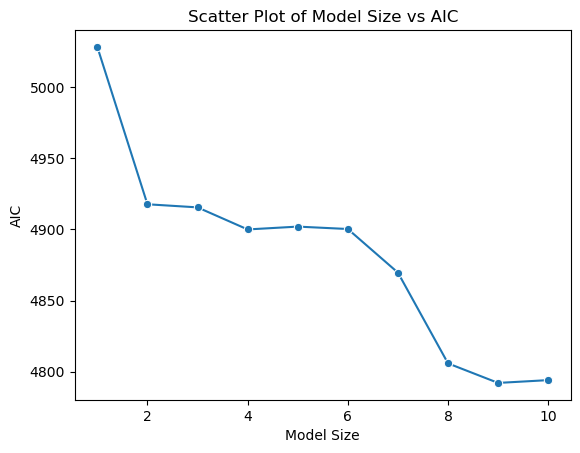

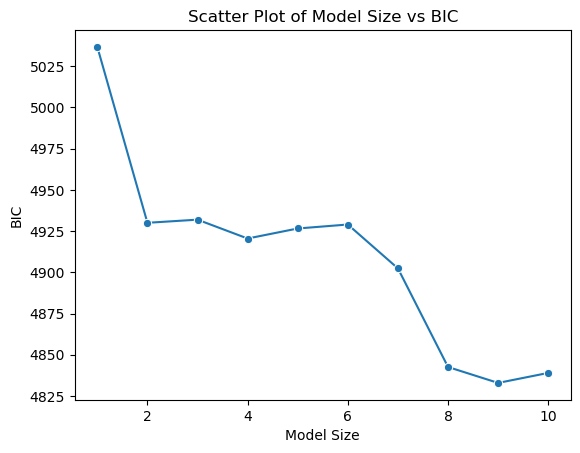

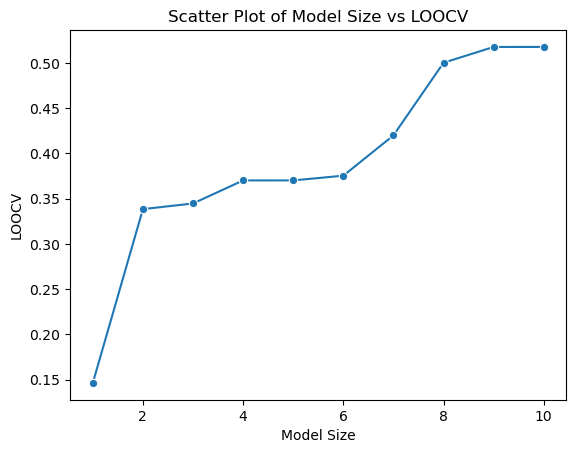

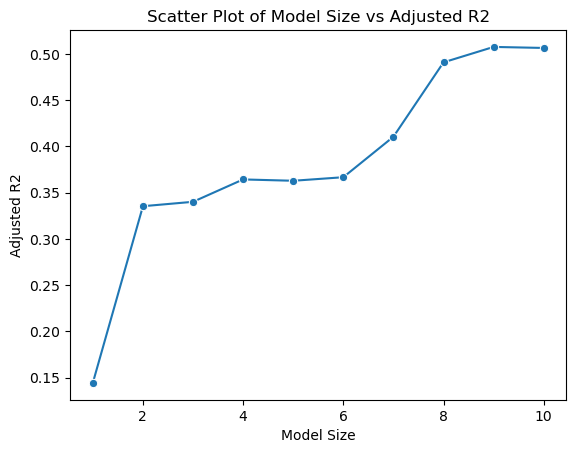

In [297]:
AIC,BIC,GCV,LOOCV,AR2=[],[],[],[],[]
for i in range(10):
    predictors=best_subset[i]
    X_temp = sm.add_constant(X[predictors])
    model = sm.OLS(Y, X_temp).fit()
    AIC.append(model.aic)
    BIC.append(model.bic)
    AR2.append(model.rsquared_adj)
    loo = LeaveOneOut()
    r2 = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        model_loocv = sm.OLS(y_train, X_train).fit()
        y_pred = model_loocv.predict(X_test)
        r2.append(model.rsquared)
    LOOCV.append(np.mean(r2))

sns.lineplot(x=[1,2,3,4,5,6,7,8,9,10], y=AIC,marker='o', markersize=6)
plt.xlabel("Model Size")
plt.ylabel("AIC")
plt.title("Scatter Plot of Model Size vs AIC")
plt.show()

sns.lineplot(x=[1,2,3,4,5,6,7,8,9,10], y=BIC,marker='o', markersize=6)
plt.xlabel("Model Size")
plt.ylabel("BIC")
plt.title("Scatter Plot of Model Size vs BIC")
plt.show()
sns.lineplot(x=[1,2,3,4,5,6,7,8,9,10], y=LOOCV,marker='o', markersize=6)
plt.xlabel("Model Size")
plt.ylabel("LOOCV")
plt.title("Scatter Plot of Model Size vs LOOCV")
plt.show()
sns.lineplot(x=[1,2,3,4,5,6,7,8,9,10], y=AR2,marker='o', markersize=6)
plt.xlabel("Model Size")
plt.ylabel("Adjusted R2")
plt.title("Scatter Plot of Model Size vs Adjusted R2")
plt.show()

The Curve is not monotonic. The reason is that these criterions penalise over-complicated model structures. The tenth feature no longer improves the performance of the model as much as the penalty incurred by the additional feature, so the score for 10 feature model is less than the score for 9 feature model. 

Model size 9 minimises AIC, BIC, and maximises Adjusted R-square. Model size 10 maximises LOOCV. 

### (e) Compare the models selected by these criteria. Why are they similar or different?

They are slightly different since different criteria optimises different target loss functions. Different criteria prioritises different aspects of the model, for example BIC preferes simpler model compared to AIC and Adjusted Rsquare. Different models have different properties as well. BIC is consistent but not efficient, while AIC is efficient but not consistent.

### (f) Apply residual boostrap 100 times and report the frequency of the size of the selected model by each criterion. Summarize your observations.

In [294]:
X_with_intercept = sm.add_constant(X)
original_model = sm.OLS(Y, X_with_intercept).fit()
residuals = original_model.resid
num_bootstraps = 100
bootstrap_params = []
AIC_freq,BIC_freq,LOOCV_freq,AR2_freq=[0 for _ in range(10)],[0 for _ in range(10)],[0 for _ in range(10)],[0 for _ in range(10)]
for _ in range(num_bootstraps):
    bootstrap_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    bootstrap_y = original_model.fittedvalues + bootstrap_residuals
    AIC,BIC,GCV,LOOCV,AR2=[],[],[],[],[]
    for i in range(10):
        predictors=best_subset[i]
        X_temp = sm.add_constant(X[predictors])
        model = sm.OLS(bootstrap_y, X_temp).fit()
        AIC.append(model.aic)
        BIC.append(model.bic)
        AR2.append(model.rsquared_adj)
        loo = LeaveOneOut()
        r2 = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = bootstrap_y.iloc[train_index], bootstrap_y.iloc[test_index]
            model_loocv = sm.OLS(y_train, X_train).fit()
            y_pred = model_loocv.predict(X_test)
            r2.append(model.rsquared)
        LOOCV.append(np.mean(r2))
    AIC_freq[AIC.index(min(AIC))]+=1
    BIC_freq[BIC.index(min(BIC))]+=1
    AR2_freq[AR2.index(max(AR2))]+=1
    LOOCV_freq[LOOCV.index(max(LOOCV))]+=1
print(AIC_freq)
print(BIC_freq)
print(AR2_freq)
print(LOOCV_freq)

[0, 0, 0, 0, 0, 0, 0, 1, 76, 23]
[0, 0, 0, 0, 0, 0, 0, 6, 92, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 64, 36]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 100]


BIC heavily favors size 9. AIC and Adjusted r-square favors size 9 but sometimes chooses size 10. LOOCV always chooses size 10 model. BIC favors smaller size models compared to AIC and adjusted r-square, and LOOCV favors larger size models.

# Lasso

### (g) Simulate a “noise” variable age1 by randomly permute the observations for age. Similarly produce a “noisy copy” for each of the 10 covariates.

In [163]:
noisy_copy=X.copy()
features = list(noisy_copy.columns)
for i in features:
    noisy_copy[i] = noisy_copy[i].sample(frac=1).reset_index(drop=True)
noisy_copy = noisy_copy.rename(columns={'x.age':'age1','x.sex':'sex1','x.bmi':'bmi1','x.map':'map1','x.tc':'tc1','x.ldl':'ldl1','x.hdl':'hdl1','x.tch':'tch1','x.ltg':'ltg1','x.glu':'glu1'})    

In [154]:
noisy_copy

,age1,sex1,bmi1,map1,tc1,ldl1,hdl1,tch1,ltg1,glu1
0,0.041708,-0.044642,-0.045007,0.032201,-0.096510,-0.104340,0.000779,0.034309,0.070211,0.081764
1,0.019913,-0.044642,-0.042852,0.087287,-0.075870,0.053174,-0.072854,0.071210,0.045601,-0.025930
2,0.063504,-0.044642,0.005650,-0.022885,-0.029088,0.057871,-0.024993,-0.002592,-0.056158,-0.067351
3,-0.005515,-0.044642,-0.030996,-0.036656,-0.016704,-0.024174,-0.032356,-0.002592,0.074968,0.061054
4,-0.027310,0.050680,-0.041774,0.011544,0.001183,-0.055802,-0.069172,-0.039493,0.133599,-0.071494
...,...,...,...,...,...,...,...,...,...,...
437,-0.038207,-0.044642,-0.066563,0.001215,0.020446,-0.032629,0.048640,-0.002592,0.132373,-0.054925
438,0.030811,0.050680,-0.004050,0.011544,-0.034592,0.005262,-0.065491,-0.039493,0.057104,-0.050783
439,0.074401,0.050680,-0.033151,-0.005671,0.024574,-0.012900,-0.072854,0.071210,0.015567,0.023775
440,0.027178,0.050680,-0.008362,0.087287,-0.008449,0.004636,-0.036038,-0.002592,-0.041180,-0.050783


### (h) Run Lasso with all 20 covariates, both the original 10 and the 10 added in (g). Plot the solution path.

In [164]:
scaler = StandardScaler()
X_20covariate= pd.concat([X, noisy_copy], axis=1)

X_standardized = scaler.fit_transform(X_20covariate)
alphas = np.logspace(-4, 3, 100)

coefs = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_standardized, Y)
    coefs.append(model.coef_)


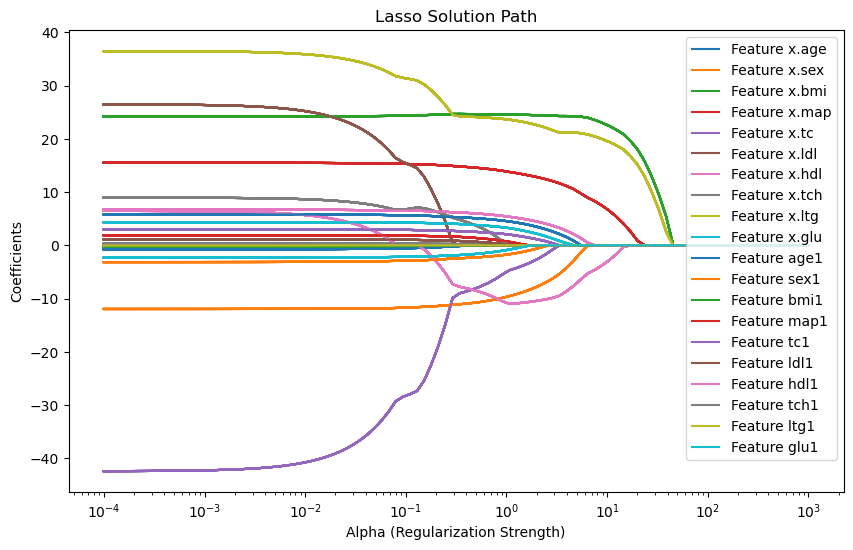

In [165]:
feature_name=list(X_20covariate.columns)
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(alphas, coefs)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficients')
plt.title('Lasso Solution Path')
plt.legend(['Feature {}'.format(feature_name[i]) for i in range(20)], loc='upper right')
plt.show()


### (i) Perform 10 fold cross validation and identify the Lasso estimate. How many “noisy” variables were selected?

In [168]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 3, 100), cv=10)
y=Y.to_numpy()
y=y.ravel()
lasso_cv.fit(X_20covariate, y)
print("Lasso Estimate (alpha):", lasso_cv.alpha_)
print("Lasso Estimate (coefficients):",lasso_cv.coef_)


Lasso Estimate (alpha): 0.0792482898353917
Lasso Estimate (coefficients): [  -0.         -176.23507037  514.69637087  275.97619118  -70.56254355
   -0.         -223.64219026    0.          482.68316078   53.33921986
   80.77926741  -20.63816047   -0.            0.           30.15952198
    0.          100.63267774    0.           -0.           -0.        ]


4 'noisy' variable was selected

### (j) Repeat (g)-(i) without plotting the solution path for 100 times, and report the frequency that each variable is selected in the final model. Summarize your observations.

In [284]:
counter=[0 for _ in range(20)]
for j in range(100):
    noisy_copy=X.copy()
    features = list(noisy_copy.columns)
    for i in features:
        noisy_copy[i] = noisy_copy[i].sample(frac=1).reset_index(drop=True)
    scaler = StandardScaler()
    X_20covariate= pd.concat([X, noisy_copy], axis=1)
    lasso_cv = LassoCV(alphas=np.logspace(-4, 3, 100), cv=10)
    y=Y.to_numpy()
    y=y.ravel()
    lasso_cv.fit(X_20covariate, y)
    for i in range(20):
        if lasso_cv.coef_[i] !=0:
            counter[i]+=1
print(counter)            
            

[0, 100, 100, 100, 100, 0, 100, 0, 100, 100, 35, 41, 52, 57, 46, 55, 49, 52, 41, 44]


Observation: The same 7 original features that were selected in (i) were selected 100 times, and the same 3 original feature that were not selected in (i) were never selected. For the noisy features, they are selected around 40 to 50 times among the 100 iterations.

# OLS

### (k) Run least squares estimate of y vs x, without variable selection. Run diagnosis for the fit to check potential violation of the the usual assumptions for linear regression,

In [389]:
X_with_intercept = sm.add_constant(X)
ols_model = sm.OLS(Y, X_with_intercept).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           3.83e-62
Time:                        07:56:16   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

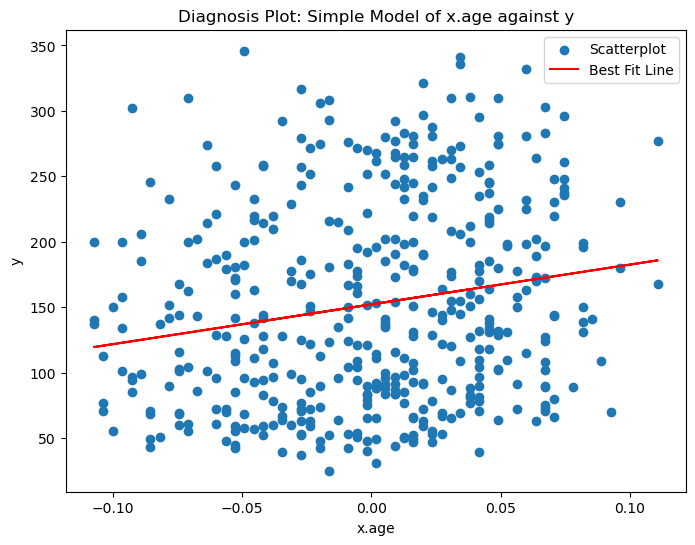

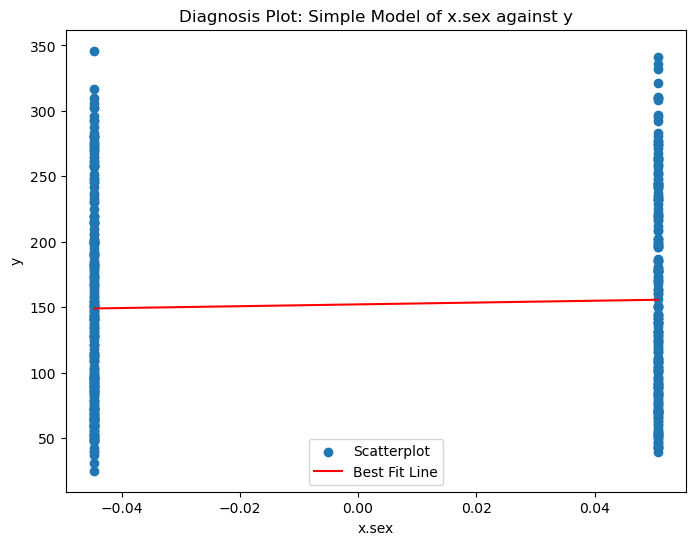

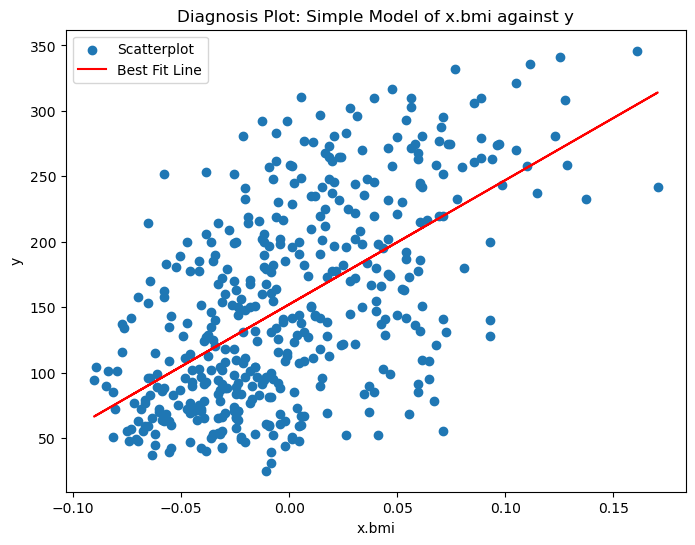

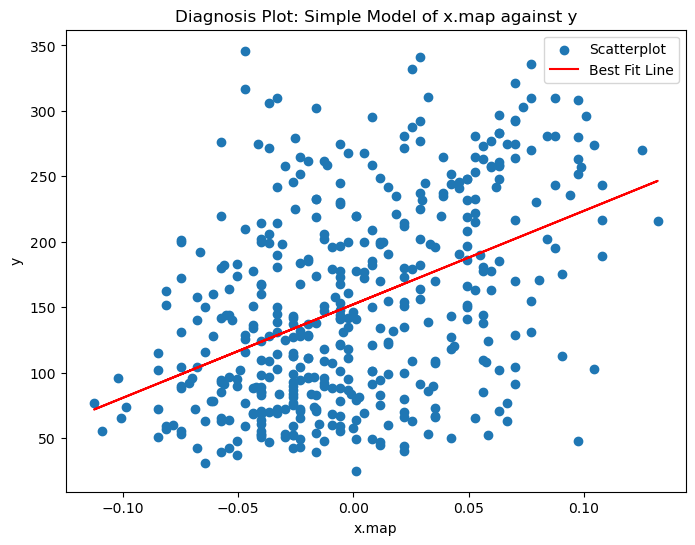

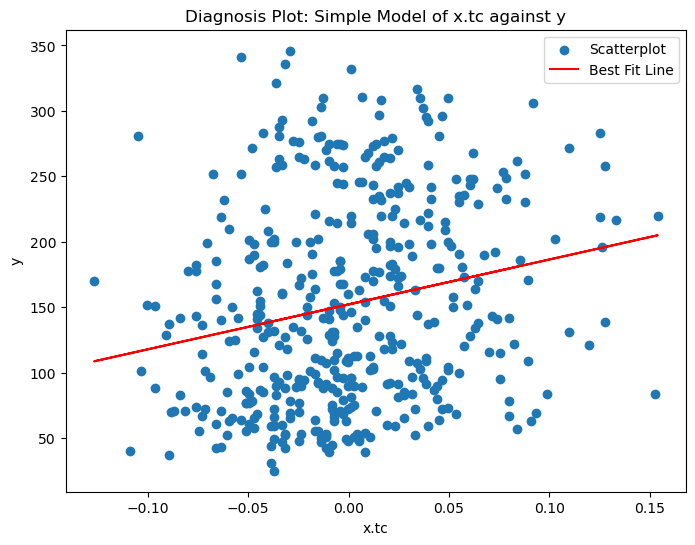

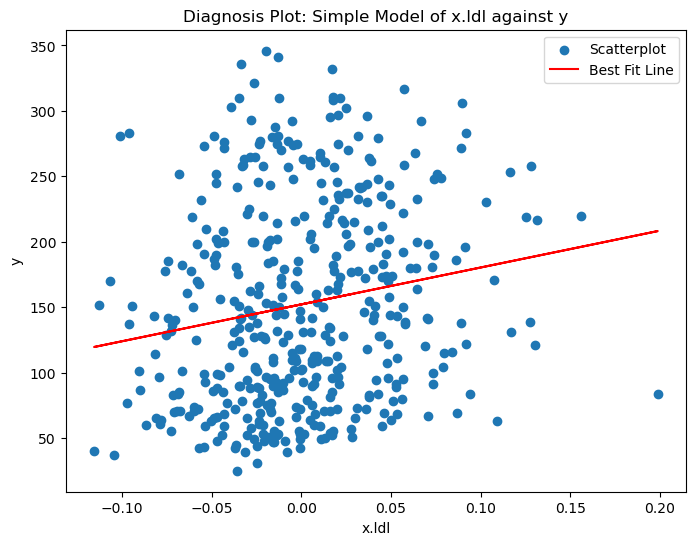

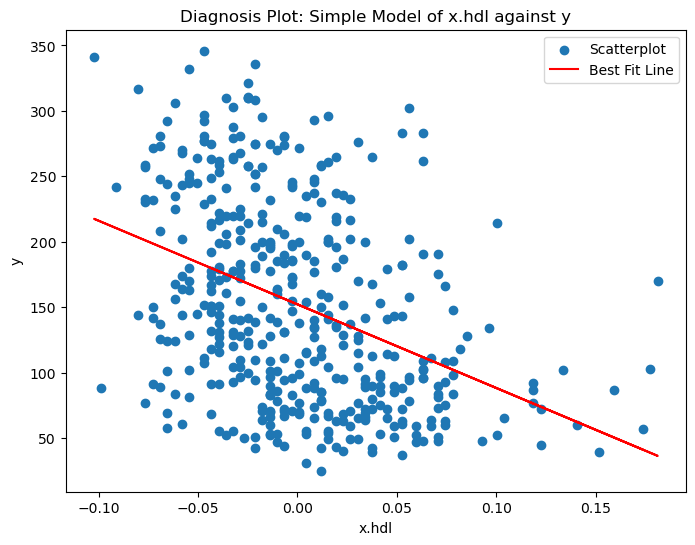

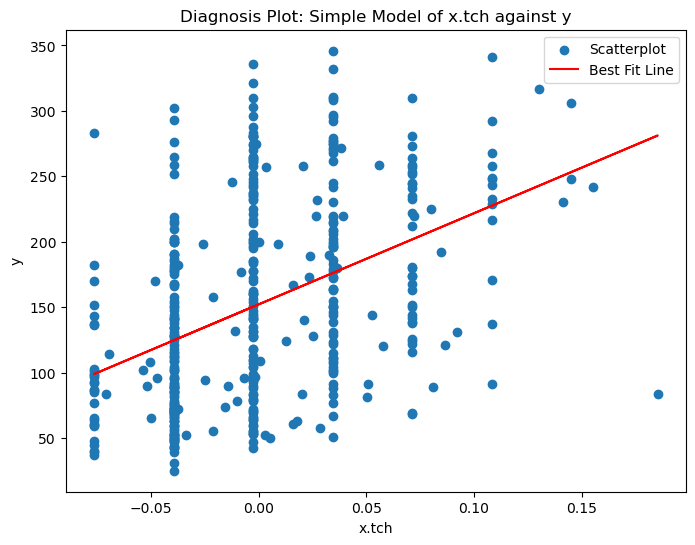

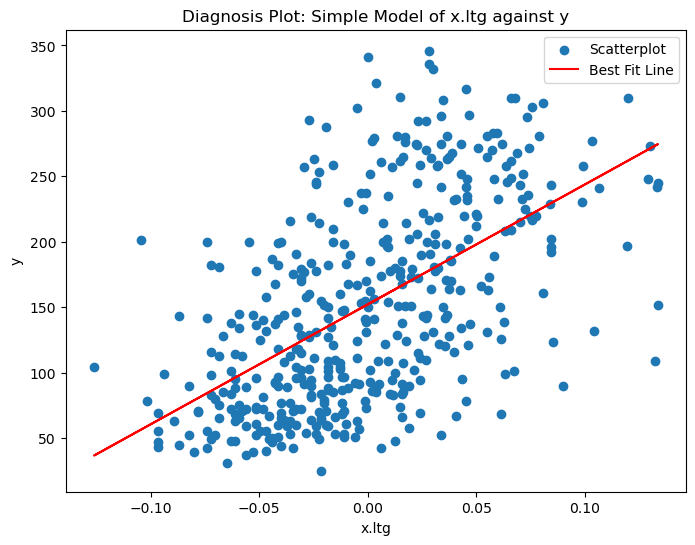

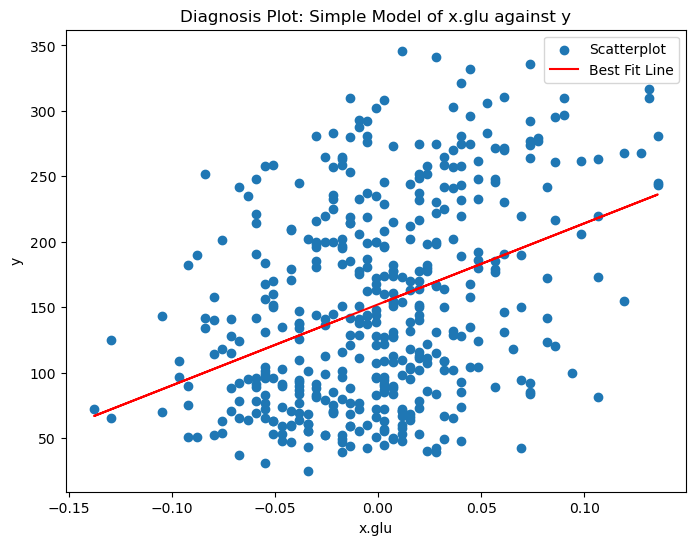

In [378]:
for i in list(X.columns):
    simple_X_with_intercept = sm.add_constant(X[i])
    simple_model = sm.OLS(Y, simple_X_with_intercept).fit()
    plt.figure(figsize=(8, 6))
    plt.scatter(X[i], Y, label='Scatterplot')
    plt.plot(X[i], simple_model.predict(simple_X_with_intercept), color='red', label='Best Fit Line')
    plt.xlabel(f'{i}')
    plt.ylabel('y')
    plt.title(f'Diagnosis Plot: Simple Model of {i} against y')
    plt.legend()
    plt.show()    

From the graph, some of the independent variables do not form a Linear Relationship with the dependent variable. Some of the features (such as x.sex) have binary inputs, and a logistic regression is more suitable than a linear regression.

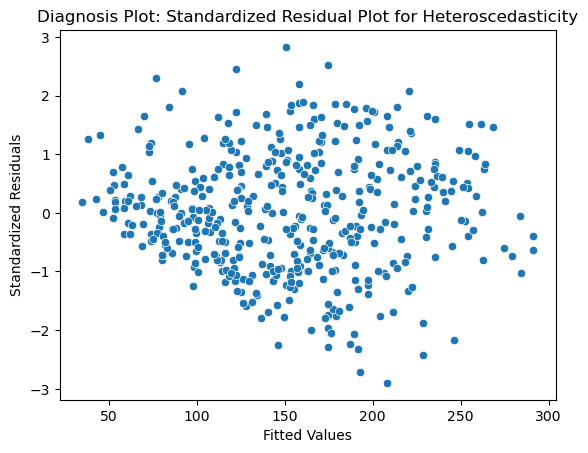

In [374]:
standardized_residuals = ols_model.get_influence().resid_studentized_internal
sns.scatterplot(x=ols_model.fittedvalues, y=standardized_residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.title("Diagnosis Plot: Standardized Residual Plot for Heteroscedasticity")
plt.show()

From the graph, Heteroscedasticity seems to be evident in the model. This violates the assumption that the noise is same level across all datapoints.

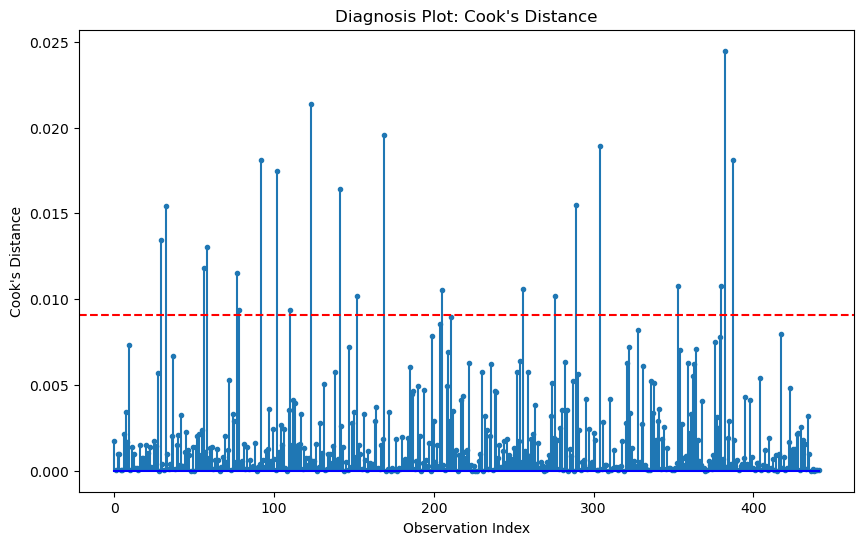

In [376]:
influence = ols_model.get_influence()
cooks_distance = influence.cooks_distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_distance[0])), cooks_distance[0], markerfmt=".", basefmt="b-")
plt.axhline(y=4/len(Y), color='r', linestyle='--')
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Diagnosis Plot: Cook's Distance")
plt.show()

From the graph, if we use the 4/n rule of thumb as given by existing literature, there are 22 outliers among the 442 numeber of datapoints.

### (l) Construct confidence intervals for the regression coeﬀicients.

In [393]:
coef_names = X_with_intercept.columns.tolist() + ['Intercept']
conf_int = ols_model.conf_int(alpha=0.05)
for idx, (coef, (lower, upper)) in enumerate(zip(ols_model.params, conf_int.values)):
    print(f"Coefficient {coef_names[idx]}:")
    print(f"  Mean: {coef:.4f}")
    print(f"  95% Confidence Interval: [{lower:.4f},{upper:.4f}]")
    print(f"  Width of 95% Confidence Interval: {upper - lower}\n")

Coefficient const:
  Mean: 152.1335
  95% Confidence Interval: [147.0707,157.1963]
  Width of 95% Confidence Interval: 10.1255875204684

Coefficient x.age:
  Mean: -10.0122
  95% Confidence Interval: [-127.4482,107.4238]
  Width of 95% Confidence Interval: 234.8720566292642

Coefficient x.sex:
  Mean: -239.8191
  95% Confidence Interval: [-360.1505,-119.4876]
  Width of 95% Confidence Interval: 240.66288549347865

Coefficient x.bmi:
  Mean: 519.8398
  95% Confidence Interval: [389.0692,650.6104]
  Width of 95% Confidence Interval: 261.54121297569856

Coefficient x.map:
  Mean: 324.3904
  95% Confidence Interval: [195.8047,452.9762]
  Width of 95% Confidence Interval: 257.1714717283792

Coefficient x.tc:
  Mean: -792.1842
  95% Confidence Interval: [-1611.1695,26.8011]
  Width of 95% Confidence Interval: 1637.9706117168344

Coefficient x.ldl:
  Mean: 476.7458
  95% Confidence Interval: [-189.6208,1143.1125]
  Width of 95% Confidence Interval: 1332.7333409216435

Coefficient x.hdl:
  Mea

### (m) Construct bootstrap, both case resampling and residual resampling, confidence intervals for the linear regression coeﬀicients. Compare these confidence intervals with those obtained in (l).

In [397]:
X_with_intercept = sm.add_constant(X)
ols_model = sm.OLS(Y, X_with_intercept).fit()
num_bootstraps = 1000
bootstrap_params = []
for _ in range(num_bootstraps):
    bootstrap_indices = np.random.choice(data.index, size=len(data), replace=True)
    bootstrap_x = X.loc[bootstrap_indices]
    bootstrap_y=Y.loc[bootstrap_indices]
    bootstrap_x_with_intercept = sm.add_constant(bootstrap_x)
    bootstrap_model = sm.OLS(bootstrap_y, bootstrap_x_with_intercept).fit()
    bootstrap_params.append(bootstrap_model.params)
confidence_intervals = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)
res=[]
print("0.025 - 0.975 Confidence Intervals for Case Resampling Regression Coefficients:\n")
for i in range(11):
    upper=confidence_intervals[1][i]
    lower=confidence_intervals[0][i]
    print(f"Coefficient {coef_names[i]}:")
    print(f"  Mean: {(upper+lower)/2:.4f}")
    print(f"  95% Confidence Interval: [{lower:.4f},{upper:.4f}]")
    print(f"  Width of 95% Confidence Interval: {upper - lower:.4f}\n")

0.025 - 0.975 Confidence Intervals for Case Resampling Regression Coefficients:

Coefficient const:
  Mean: 147.6292
  95% Confidence Interval: [133.8136,161.4449]
  Width of 95% Confidence Interval: 27.6313

Coefficient x.age:
  Mean: 36.7007
  95% Confidence Interval: [-200.6623,274.0637]
  Width of 95% Confidence Interval: 474.7260

Coefficient x.sex:
  Mean: -384.6571
  95% Confidence Interval: [-666.8228,-102.4914]
  Width of 95% Confidence Interval: 564.3315

Coefficient x.bmi:
  Mean: 453.0177
  95% Confidence Interval: [78.1736,827.8618]
  Width of 95% Confidence Interval: 749.6882

Coefficient x.map:
  Mean: 131.1821
  95% Confidence Interval: [-162.3538,424.7180]
  Width of 95% Confidence Interval: 587.0718

Coefficient x.tc:
  Mean: 2581.7296
  95% Confidence Interval: [-1030.1257,6193.5848]
  Width of 95% Confidence Interval: 7223.7105

Coefficient x.ldl:
  Mean: -2664.7227
  95% Confidence Interval: [-5705.0466,375.6011]
  Width of 95% Confidence Interval: 6080.6478

Coeff

In [398]:
X_with_intercept = sm.add_constant(X)
ols_model = sm.OLS(Y, X_with_intercept).fit()
num_bootstraps = 1000
bootstrap_params = []
for _ in range(num_bootstraps):
    bootstrap_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    bootstrap_y = original_model.fittedvalues + bootstrap_residuals
    bootstrap_model = sm.OLS(bootstrap_y, X_with_intercept).fit()
    bootstrap_params.append(bootstrap_model.params)
confidence_intervals = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)
res=[]
print("0.025 - 0.975 Confidence Intervals for Residual Resampling Regression Coefficients:")
for i in range(11):
    upper=confidence_intervals[1][i]
    lower=confidence_intervals[0][i]
    print(f"Coefficient {coef_names[i]}:")
    print(f"  Mean: {(upper+lower)/2:.4f}")
    print(f"  95% Confidence Interval: [{lower:.4f},{upper:.4f}]")
    print(f"  Width of 95% Confidence Interval: {upper - lower:.4f}\n")

0.025 - 0.975 Confidence Intervals for Residual Resampling Regression Coefficients:
Coefficient const:
  Mean: 152.1119
  95% Confidence Interval: [147.1254,157.0983]
  Width of 95% Confidence Interval: 9.9729

Coefficient x.age:
  Mean: -10.0779
  95% Confidence Interval: [-125.1170,104.9612]
  Width of 95% Confidence Interval: 230.0782

Coefficient x.sex:
  Mean: -243.5133
  95% Confidence Interval: [-359.5080,-127.5186]
  Width of 95% Confidence Interval: 231.9893

Coefficient x.bmi:
  Mean: 516.7379
  95% Confidence Interval: [387.6426,645.8333]
  Width of 95% Confidence Interval: 258.1906

Coefficient x.map:
  Mean: 323.3579
  95% Confidence Interval: [202.2130,444.5027]
  Width of 95% Confidence Interval: 242.2896

Coefficient x.tc:
  Mean: -794.2052
  95% Confidence Interval: [-1592.1549,3.7444]
  Width of 95% Confidence Interval: 1595.8993

Coefficient x.ldl:
  Mean: 484.6298
  95% Confidence Interval: [-150.2018,1119.4614]
  Width of 95% Confidence Interval: 1269.6632

Coeffic

Case resampling produces much wider confidence interval than (i). Residual resampling produces slightly tighter interval than (i). In general, case resampling gives wider confidence intervals.